In [94]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from PIL import Image
import os

In [95]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [96]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [97]:
import zipfile
import os
from pathlib import Path

### Step 1 : Dataset Preparation - For Tomato Dataset

In [98]:
# Dataset Configuration
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

TOMATO_CLASSES = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 
    'Tomato__Target_Spot',  
    'Tomato__Tomato_YellowLeaf__Curl_Virus', 
    'Tomato__Tomato_mosaic_virus', 
    'Tomato_healthy'
]

In [99]:
EXTRACT_PATH = "PlantVillage" 
def prepare_binary_dataset():
    all_images = []
    binary_labels = []
    
    for class_name in os.listdir(EXTRACT_PATH):
        image_dir = os.path.join(EXTRACT_PATH, class_name)
        if os.path.isdir(image_dir):
            is_tomato = 1 if class_name.startswith('Tomato') else 0
            for image_file in os.listdir(image_dir):
                try:
                    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_path = os.path.join(image_dir, image_file)
                        img = tf.keras.preprocessing.image.load_img(
                            image_path, 
                            target_size=(IMAGE_SIZE, IMAGE_SIZE)
                        )
                        img_array = tf.keras.preprocessing.image.img_to_array(img)
                        img_array = img_array / 255.0  # Normalize pixel values
                        all_images.append(img_array)
                        binary_labels.append([is_tomato])  # Make labels 2D
                except Exception as e:
                    print(f"Error loading image {image_file}: {str(e)}")
                    continue
    
    # Convert to numpy arrays with proper shapes
    X = np.array(all_images, dtype=np.float32)
    y = np.array(binary_labels, dtype=np.float32)
    
    # Create TensorFlow dataset
    binary_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    binary_dataset = binary_dataset.shuffle(1000).batch(BATCH_SIZE)
    
    # Split into train and validation
    dataset_size = len(binary_labels)
    train_size = int(0.8 * dataset_size)
    
    train_ds = binary_dataset.take(train_size)
    val_ds = binary_dataset.skip(train_size)
    
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {dataset_size - train_size}")
    
    return train_ds, val_ds

In [100]:
# Create disease classification dataset (only tomato diseases)
def prepare_disease_dataset():
    # Only include tomato folders
    tomato_images = []
    disease_labels = []
    
    for idx, class_name in enumerate(TOMATO_CLASSES):
        image_dir = os.path.join(EXTRACT_PATH, class_name)
        if os.path.isdir(image_dir):
            for image_file in os.listdir(image_dir):
                if image_file.endswith(('.jpg', '.jpeg', '.png', 'JPG')):
                    image_path = os.path.join(image_dir, image_file)
                    img = tf.keras.preprocessing.image.load_img(
                        image_path, 
                        target_size=(IMAGE_SIZE, IMAGE_SIZE)
                    )
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    tomato_images.append(img_array)
                    disease_labels.append(idx)  
    
    # Convert to numpy arrays
    X = np.array(tomato_images)
    y = np.array(disease_labels)
    
    # Create TensorFlow dataset
    disease_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    disease_dataset = disease_dataset.shuffle(1000).batch(BATCH_SIZE)
    
    # Split into train and validation
    dataset_size = len(disease_labels)
    train_size = int(0.8 * dataset_size)
    
    train_ds = disease_dataset.take(train_size)
    val_ds = disease_dataset.skip(train_size)
    
    return train_ds, val_ds


In [101]:
import tensorflow as tf
import os

# Print extracted folder contents
print("Extracted folder contents:")
print(os.listdir(EXTRACT_PATH))

# List class folders inside extracted path
class_folders = os.listdir(EXTRACT_PATH)
print("Class folders:", class_folders)

# Define constants
IMAGE_SIZE = 224  # Adjust based on your model's input size
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    EXTRACT_PATH,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Load and split the dataset
dataset_2 = tf.keras.preprocessing.image_dataset_from_directory(
    EXTRACT_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=TOMATO_CLASSES
)

validation_dataset_2 = tf.keras.preprocessing.image_dataset_from_directory(
    EXTRACT_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=TOMATO_CLASSES
)
# Print detected class names
print("Class names:", dataset.class_names)
print("Class names:", dataset_2.class_names)

Extracted folder contents:
['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Class folders: ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


Found 18163 files belonging to 13 classes.
Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [102]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

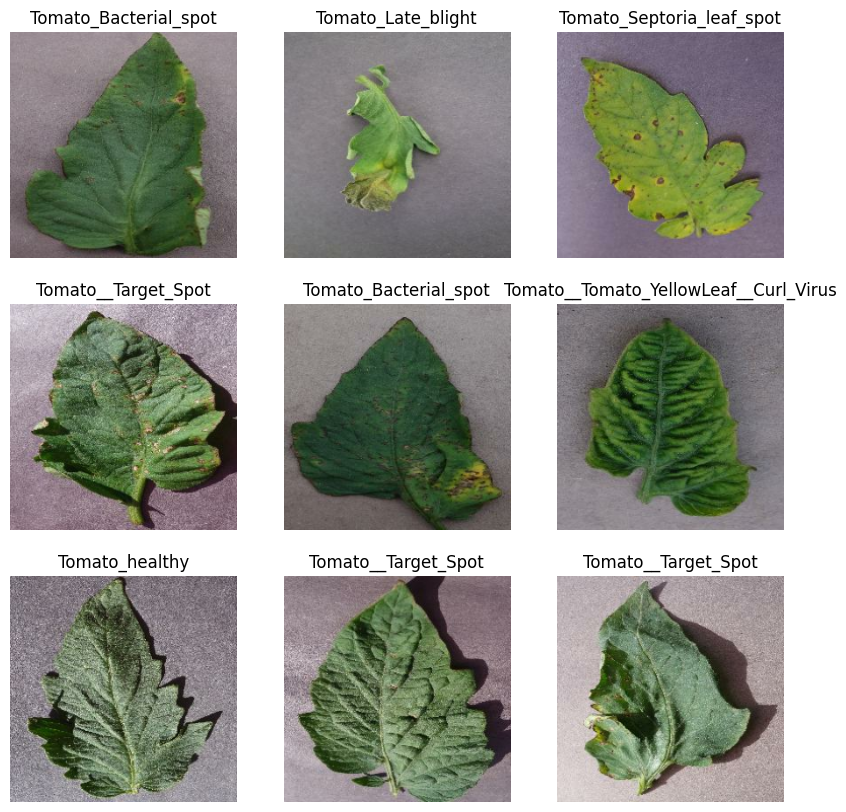

In [103]:
# Visualize some samples
plt.figure(figsize=(10, 10))
for images, labels in dataset_2.take(1):  
    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(TOMATO_CLASSES[labels[i]])  
        plt.axis("off")
plt.show()

In [104]:
input_shape_2 = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes_2 = len(TOMATO_CLASSES)  

### Step 2 : Create two models for Tomato Dataset


In [105]:
# Binary Classification Model
def create_binary_model(input_shape_2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape_2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    return model

In [106]:
def create_disease_model(input_shape_2, num_classes_2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape_2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes_2, activation='softmax')  
    ])
    return model

In [107]:
# Initialize models
input_shape_2 = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
binary_model = create_binary_model(input_shape_2)
disease_model = create_disease_model(input_shape_2, len(TOMATO_CLASSES))

In [108]:
# Compile models
binary_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

disease_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [109]:
# Print model summaries
print("Binary Classification Model (Tomato vs Non-tomato):")
binary_model.summary()

print("\nDisease Classification Model:")
disease_model.summary()

Binary Classification Model (Tomato vs Non-tomato):


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,345 (10.78 MB)

 Trainable params: 2,825,345 (10.78 MB)

 Non-trainable params: 0 (0.00 B)


Disease Classification Model:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,930 (10.78 MB)

 Trainable params: 2,825,930 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

### Step 4 : Training proecess for tomato dataset

In [110]:
# Create binary datasets
binary_train_ds, binary_val_ds = prepare_binary_dataset()

# Train binary model
binary_history = binary_model.fit(
    binary_train_ds,
    validation_data=binary_val_ds,
    epochs=EPOCHS
)

Error loading image 001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG: Could not import PIL.Image. The use of `load_img` requires PIL.
Error loading image 002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG: Could not import PIL.Image. The use of `load_img` requires PIL.
Error loading image 009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG: Could not import PIL.Image. The use of `load_img` requires PIL.
Error loading image 00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG: Could not import PIL.Image. The use of `load_img` requires PIL.
Error loading image 0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG: Could not import PIL.Image. The use of `load_img` requires PIL.
Error loading image 02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG: Could not import PIL.Image. The use of `load_img` requires PIL.
Error loading image 0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG: Could not import PIL.Image. The use of `load_img` requir

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None,), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None,), dtype=float32)
  • training=True
  • mask=None

In [28]:
# Add these visualization functions
def plot_training_history(history_2, title_2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history_2.history['accuracy'])
    ax1.plot(history_2.history['val_accuracy'])
    ax1.set_title(f'{title_2} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'])
    
    # Loss plot
    ax2.plot(history_2.history['loss'])
    ax2.plot(history_2.history['val_loss'])
    ax2.set_title(f'{title_2} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'])
    
    plt.tight_layout()
    plt.show()



In [29]:
# Test function for models
def test_models(binary_model, disease_model, test_image_path):
    img = tf.keras.preprocessing.image.load_img(
        test_image_path, 
        target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, 0)
    
    # Test binary classification
    is_tomato = binary_model.predict(img_batch)[0][0]
    print(f"Is Tomato Confidence: {is_tomato:.2f}")
    
    if is_tomato >= 0.5:
        # Test disease classification
        disease_pred = disease_model.predict(img_batch)
        predicted_class = TOMATO_CLASSES[np.argmax(disease_pred[0])]
        confidence = np.max(disease_pred[0])
        print(f"Disease: {predicted_class}")
        print(f"Confidence: {confidence:.2f}")
    else:
        print("Not a tomato leaf")

In [30]:
# Test with a tomato image
test_models(binary_model, disease_model, "path/to/test/tomato_image.jpg")

# Plot training history
plot_training_history(binary_history, "Binary Classification")
plot_training_history(disease_history, "Disease Classification")

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

#### NON-Tomato section 

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


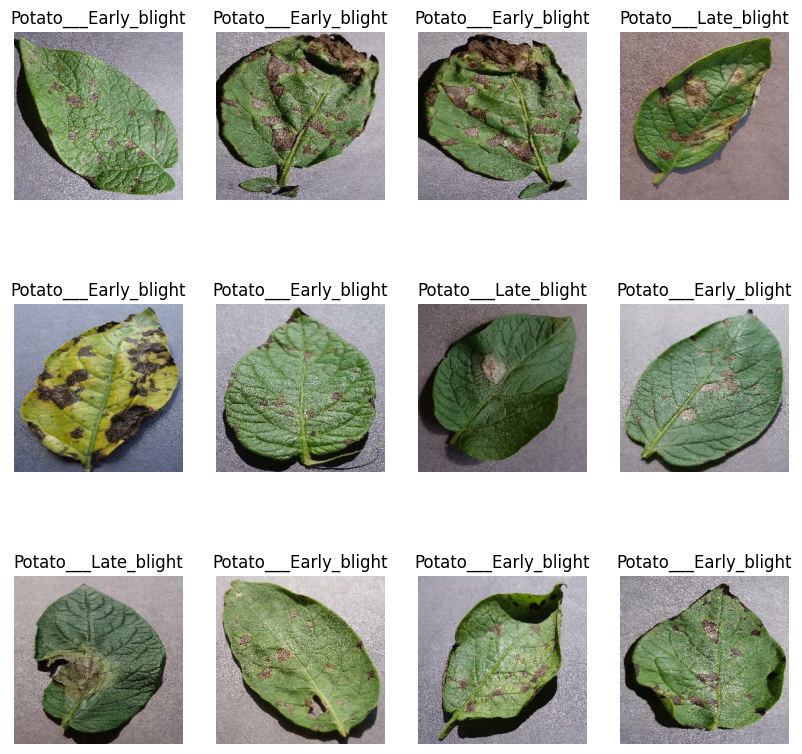

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_129 (Conv2D)                  │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_132 (MaxPooling2D)     │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_133 (MaxPooling2D)     │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_134 (MaxPooling2D)     │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_132 (Conv2D)                  │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_135 (MaxPooling2D)     │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_136 (MaxPooling2D)     │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_134 (Conv2D)                  │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_137 (MaxPooling2D)     │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.9468 - loss: 0.1411 - val_accuracy: 0.9427 - val_loss: 0.1498
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.9620 - loss: 0.1086 - val_accuracy: 0.9583 - val_loss: 0.1205
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.9655 - loss: 0.1005 - val_accuracy: 0.9167 - val_loss: 0.1645
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.9463 - loss: 0.1265 - val_accuracy: 0.8490 - val_loss: 0.3916
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.9380 - loss: 0.1753 - val_accuracy: 0.9479 - val_loss: 0.1106
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.9677 - loss: 0.0828 - val_accuracy: 0.8906 - val_loss: 0.2630
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9628 - loss: 0.0949 - val_accuracy: 0.9375 - val_loss: 0.1770
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.9539 - loss: 0.1127 - val_accuracy: 0.9375 - v

In [ ]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9901 - loss: 0.0448


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

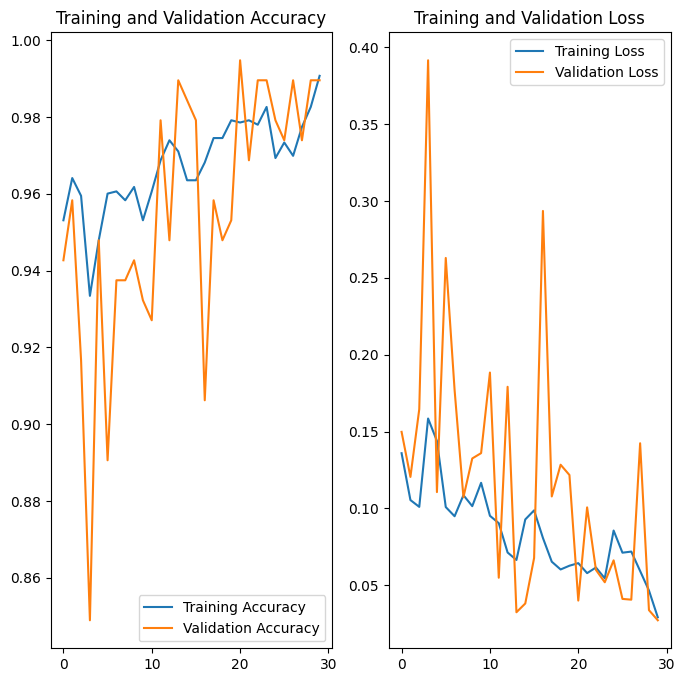

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Potato___Early_blight


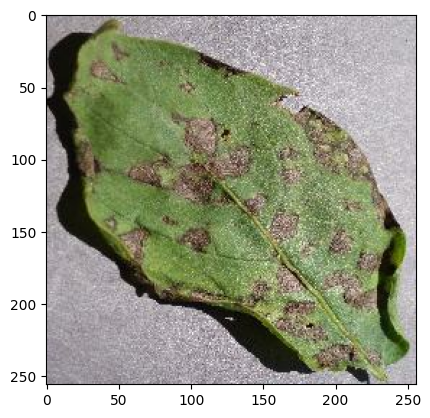

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.save('potato.keras')

from google.colab import files
files.download('potato.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>